In [1]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import datetime
from google.colab import drive
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import seaborn as sns
from scipy.stats.mstats import winsorize
import sklearn
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Analysis**

***1. Read Data***

In [ ]:
train_transaction = pd.read_csv('/content/drive/MyDrive/IFE/train_transaction.csv')
test_transaction = pd.read_csv('/content/drive/MyDrive/IFE/test_transaction.csv')
train_identity = pd.read_csv('/content/drive/MyDrive/IFE/train_identity.csv')
test_identity = pd.read_csv('/content/drive/MyDrive/IFE/test_identity.csv')
print(train_transaction.shape, test_transaction.shape, train_identity.shape, test_identity.shape)

(590540, 394) (506691, 393) (144233, 41) (141907, 41)


In [ ]:
print(train_transaction.info())
print(test_transaction.info())
print(train_identity.info())
print(test_identity.info())

***2. Analysis***

In [ ]:
print(np.sum(train_transaction['TransactionID'].isin(train_identity['TransactionID'].unique())))
print(np.sum(test_transaction['TransactionID'].isin(test_identity['TransactionID'].unique())))

144233
141907


In [ ]:
print(len(train_transaction[train_transaction['isFraud'] == 1]))
print(len(train_transaction[train_transaction['isFraud'] == 0]))
# print(len(test_transaction[test_transaction['isFraud'] == 1]))
# print(len(test_transaction[test_transaction['isFraud'] == 0]))

20663
569877


In [ ]:
print("Max Fraud Transaction Amount: ", np.max(train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionAmt']))
print("Min Fraud Transaction Amount:", np.min(train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionAmt']))
print("Average Fraud Transaction Amount:", np.mean(train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionAmt']))

Max Fraud Transaction Amount:  5191.0
Min Fraud Transaction Amount: 0.292
Average Fraud Transaction Amount: 149.2447785897534


In [ ]:
print("Max Non Fraud Transaction Amount: ", np.max(train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionAmt']))
print("Min Non Fraud Transaction Amount:", np.min(train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionAmt']))
print("Average Non Fraud Transaction Amount:", np.mean(train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionAmt']))

Max Non Fraud Transaction Amount:  31937.391
Min Non Fraud Transaction Amount: 0.251
Average Non Fraud Transaction Amount: 134.51166457896034


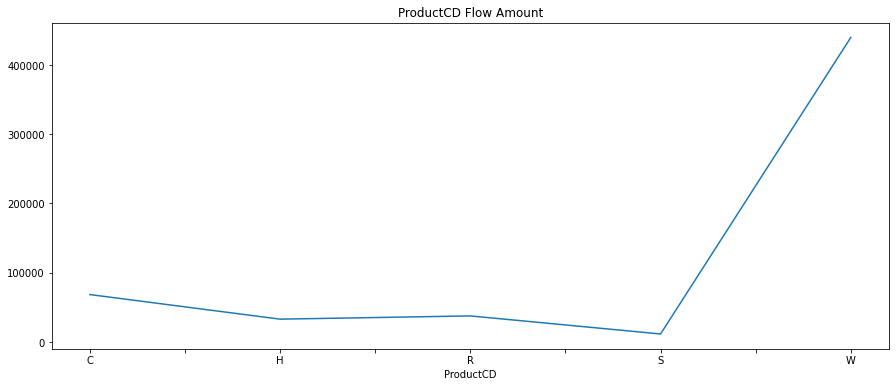

In [ ]:
train_transaction.groupby('ProductCD')['TransactionID'].count().sort_index().plot(figsize=(15, 6),title='ProductCD Flow Amount')
plt.show()

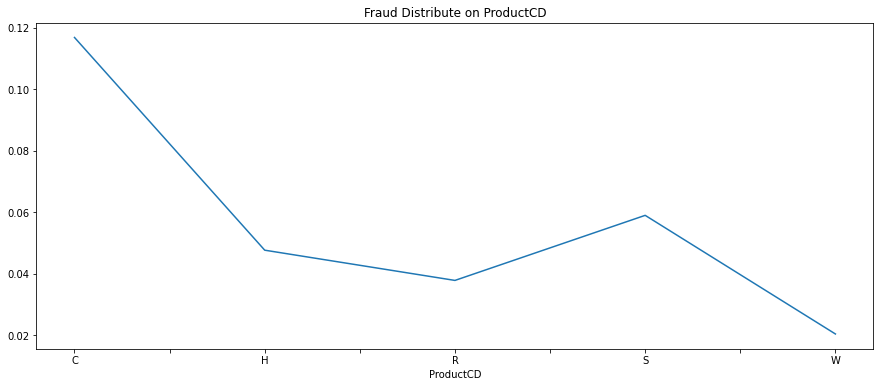

In [ ]:
train_transaction.groupby('ProductCD')['isFraud'].mean().sort_index().plot(figsize=(15, 6),title='Fraud Distribute on ProductCD')
plt.show()

In [ ]:
print(train_transaction.isnull().sum().sort_values(ascending = False))

dist2            552913
D7               551623
D13              528588
D14              528353
D12              525823
                  ...  
C11                   0
C12                   0
C13                   0
C14                   0
TransactionID         0
Length: 394, dtype: int64


In [ ]:
df_nan = pd.DataFrame({"NA amount":train_transaction.isnull().sum().sort_values(ascending=False)})
df_nan["Rate"]=df_nan["NA amount"]/len(train_transaction)
df_nan.to_csv('/content/drive/MyDrive/Results/nanEvaluate.csv', index = True)

# **II. Data Processing**

***1. Merging Table***

In [ ]:
trainSet = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
testSet = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
del train_transaction, train_identity,  test_transaction, test_identity
print(trainSet.shape)
print(testSet.shape)

(590540, 434)
(506691, 433)


In [ ]:
trainSet.drop('TransactionID', axis = 1)
testSet.drop('TransactionID', axis = 1)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,...,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,18403224,31.950,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18403263,49.000,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,634.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18403310,171.000,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18403310,284.950,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,242.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18403317,67.950,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,34214279,94.679,C,13832,375.0,185.0,mastercard,224.0,debit,284.0,60.0,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506687,34214287,12.173,C,3154,408.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,157.0,hotmail.com,hotmail.com,1.0,3.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,1.0,1.0,3.0,1.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,NaN,NaN,0.0,NaN,...,-45.0,266704.0,NaN,NaN,-3.0,-10.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 43.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,ALE-L23 Build/HuaweiALE-L23
506688,34214326,49.000,W,16661,490.0,150.0,visa,226.0,debit,327.0,87.0,NaN,NaN,hotmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506689,34214337,202.000,W,16621,516.0,150.0,mastercard,224.0,debit,177.0,87.0,NaN,NaN,hotmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...

In [ ]:
trainSet.rename(columns=lambda x: x.replace("id_","id-") if "id_" in x else x, inplace=True)

*Remove Columns which has Significant Rate of Missing Value*

In [ ]:
# Train drop columns which has significant rate of NaN.
trainDrop = []
for col in trainSet.columns:
    # print(col, ' --- total: ', trainSet.shape[0], ' --- NaN: ', trainSet[col].isnull().sum())
    if trainSet[col].isnull().sum() / trainSet.shape[0] >= 0.90:
        trainDrop.append(col)

testDrop = []
for col in testSet.columns:
    # print(col, ' --- total: ', testSet.shape[0], ' --- NaN: ', testSet[col].isnull().sum())
    if testSet[col].isnull().sum() / testSet.shape[0] >= 0.90:
        testDrop.append(col)

# print(list(set(trainDrop + testDrop)))

trainSet.drop(list(set(trainDrop + testDrop)), axis = 1, inplace = True)
testSet.drop(list(set(trainDrop + testDrop)), axis = 1, inplace = True)

In [ ]:
trainSet = pd.read_csv('/content/drive/MyDrive/Results/trainRaw.csv')
testSet = pd.read_csv('/content/drive/MyDrive/Results/testRaw.csv')

In [ ]:
for col in trainSet.columns:
    print(col, ' - ', trainSet[col].dtypes)

*String dtypes imputation*

In [ ]:
for col in testSet.columns:
    if testSet[col].dtypes == testSet['ProductCD'].dtypes:
        print(col)

ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id-12
id-15
id-16
id-28
id-29
id-30
id-31
id-33
id-34
id-35
id-36
id-37
id-38
DeviceType
DeviceInfo


In [ ]:
# impute missing value with method for hashing next step

# 1. fill nan of series which have dtypes is String
for col in testSet.columns:
    if testSet[col].dtypes == testSet['ProductCD'].dtypes:
        testSet[col].fillna('undefined-' + col, inplace = True)
        trainSet[col].fillna('undefined-' + col, inplace = True)

*Numerical imputation*

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
# 2. Numerical Imputation
for col in testSet.columns:
    if testSet[col].dtypes != testSet['ProductCD'].dtypes:
        med_imputer = IterativeImputer(estimator=RandomForestRegressor(), random_state=0)
        med_imputer.fit(trainSet[[col]])
        trainSet[[col]] = med_imputer.transform(trainSet[[col]])
        testSet[[col]] = med_imputer.transform(testSet[[col]])

*Collerative Removal*

In [ ]:
correlation_cols = []
correlation_mtx = trainSet.corr()

In [ ]:
iterate = range(len(correlation_mtx.columns) - 1)
for i in iterate:
        for j in range(i+1):
            val = correlation_mtx.iloc[j:(j+1), (i+1):(i+2)]
            col = val.columns
            row = val.index
            diff = abs(val.values)
            if diff >= 0.85: # threhold to compare 2 feature cells
                correlation_cols.append(col.values[0])

canDrop = set(correlation_cols)
print(canDrop)
print(len(canDrop))

{'V279', 'V54', 'V85', 'V158', 'V236', 'V178', 'V199', 'V84', 'V301', 'V287', 'V22', 'C10', 'V309', 'V324', 'V336', 'V52', 'V21', 'V266', 'V159', 'V71', 'V323', 'V150', 'V113', 'V318', 'V231', 'V298', 'V28', 'V96', 'V273', 'V339', 'V320', 'V13', 'V254', 'V34', 'V222', 'V212', 'V45', 'V278', 'V219', 'V103', 'V74', 'V62', 'V163', 'V218', 'V168', 'V216', 'V251', 'V134', 'V152', 'V321', 'V119', 'V262', 'V306', 'V60', 'V93', 'C9', 'V63', 'V308', 'V249', 'V295', 'V38', 'V275', 'V143', 'V40', 'V202', 'C2', 'V213', 'V30', 'V160', 'V304', 'V94', 'V237', 'V269', 'V72', 'V192', 'V196', 'V43', 'V327', 'C14', 'V57', 'V277', 'V293', 'V162', 'V70', 'V332', 'V297', 'V303', 'V204', 'V259', 'V101', 'V183', 'V180', 'V73', 'V296', 'V164', 'V50', 'V97', 'V190', 'V257', 'V80', 'V145', 'V155', 'V268', 'V245', 'V137', 'V64', 'V285', 'V133', 'V198', 'V69', 'V49', 'V207', 'V11', 'V289', 'V20', 'V253', 'V329', 'V307', 'V312', 'V334', 'C7', 'V58', 'V317', 'V330', 'V193', 'V36', 'V272', 'V333', 'V294', 'V153', 'V2

In [ ]:
trainSet = trainSet.drop(canDrop, axis=1)
testSet = testSet.drop(canDrop, axis=1)

*String dtypes Hash Encoding*

In [ ]:
import hashlib
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
def hash_modulo(val, mod):
    md5 = hashlib.md5()  # can be other deterministic hash functions
    md5.update(str(val).encode())
    return int(md5.hexdigest(), 36) % mod

class FeatureHasher(BaseEstimator, TransformerMixin):
    def __init__(self, num_buckets: int):
        self.num_buckets = num_buckets

    def fit(self, X: pd.Series):
        return self
# 2456
    def transform(self, X: pd.Series):
        return X.apply(lambda x: hash_modulo(x, self.num_buckets))

In [ ]:
lst = []
for col in testSet.columns:
    if testSet[col].dtypes == testSet['ProductCD'].dtypes:
        lst.append(col)

lst

In [ ]:
for col in lst:
    fh = FeatureHasher(num_buckets = 2456)
    testSet[col] = fh.transform(testSet[col])
    trainSet[col] = fh.transform(trainSet[col])
# After transformation
testSet.head(50)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C3,C5,C13,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,...,V305,V310,V313,V314,V319,V325,V326,V335,V337,V338,id-01,id-02,id-03,id-04,id-05,id-06,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-19,id-20,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,18403224.0,31.950,746,10409.0,111.0,150.0,531,226.0,2323,170.000000,87.00000,1.00000,2440,640,6.0,0.0,3.0,115.0,419.000000,419.000000,27.000000,398.000000,27.000000,69.805717,146.058108,0.561057,418.0,203.000000,54.037533,17.901295,57.724444,409.0,1951,1951,1926,171,1315,1926,1951,1951,...,1.0,47.950001,0.000000,0.000000,0.000000,0.058494,0.85104,59.16455,55.352422,151.160542,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.69871,0.091023,-0.301124,99.745325,2136,48.053071,-344.507146,476,2109,189.451377,353.128174,403.882666,2373,2014,1984,1651,26.508597,1155,400,1588,1727,235,2180,267,1493
1,18403263.0,49.000,746,4272.0,111.0,150.0,531,226.0,2323,299.000000,87.00000,4.00000,1473,640,3.0,0.0,0.0,12.0,149.000000,149.000000,7.000000,634.000000,7.000000,69.805717,146.058108,0.561057,231.0,634.000000,54.037533,17.901295,57.724444,634.0,1951,1926,1926,1452,1315,1926,2163,2191,...,1.0,280.000000,0.000000,0.000000,0.000000,0.058494,0.85104,59.16455,55.352422,151.160542,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.69871,0.091023,-0.301124,99.745325,2136,48.053071,-344.507146,476,2109,189.451377,353.128174,403.882666,2373,2014,1984,1651,26.508597,1155,400,1588,1727,235,2180,267,1493
2,18403310.0,171.000,746,4476.0,574.0,150.0,531,226.0,2323,472.000000,87.00000,2635.00000,1311,640,2.0,0.0,0.0,22.0,137.000000,137.000000,10.000000,97.000000,10.000000,69.805717,146.058108,0.561057,136.0,136.000000,54.037533,17.901295,57.724444,97.0,1951,1951,1926,1452,1926,1926,1926,1926,...,1.0,1058.000000,0.000000,0.000000,0.000000,0.058494,0.85104,59.16455,55.352422,151.160542,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.69871,0.091023,-0.301124,99.745325,2136,48.053071,-344.507146,476,2109,189.451377,353.128174,403.882666,2373,2014,1984,1651,26.508597,1155,400,1588,1727,235,2180,267,1493
3,18403310.0,284.950,746,10989.0,360.0,150.0,531,166.0,2323,205.000000,87.00000,17.00000,2440,640,5.0,0.0,1.0,7.0,42.000000,42.000000,41.000000,242.000000,41.000000,69.805717,146.058108,0.561057,242.0,242.000000,54.037533,17.901295,57.724444,242.0,1951,1951,1951,171,1315,1951,2163,2191,...,1.0,0.000000,282.540009,282.540009,0.000000,0.058494,0.85104,59.16455,55.352422,151.160542,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.69871,0.091023,-0.301124,99.745325,2136,48.053071,-344.507146,476,2109,189.451377,353.128174,403.882666,2373,2014,1984,1651,26.508597,1155,400,1588,1727,235,2180,267,1493
4,18403317.0,67.950,746,18018.0,452.0,150.0,1239,117.0,2323,264.000000,87.00000,6.00000,2440,640,6.0,0.0,2.0,14.0,22.000000,22.000000,0.000000,22.000000,0.000000,69.805717,146.058108,0.561057,22.0,22.000000,54.037533,17.901295,57.724444,22.0,1951,1951,1951,171,1315,1926,1926,1951,...,1.0,183.850006,67.949997,183.850006,0.000000,0.058494,0.85104,59.16455,55.352422,151.160542,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.69871,0.091023,-0.301124,99.745325,2136,48.053071,-344.507146,476,2109,189.451377,353.128174,403.882666,2373,2014,1984,1651,26.508597,1155,400,1588,1727,235,2180,267,1493
5,18403323.0,57.950,746,12839.0,321.0,150.0,531,226.0,2323,512.000000,87.00000,118.50218,2440,640,5.0,0.0,2.0,10.0,36.000000,36.000000,35.000000,0.000000,42.335965,69.805717,146.058108,0.561057,0.0,0.000000,54.037533,17.901295,57.724444,0.0,1951,1951,1951,171,1315,1951,1926,1926,...,1.0,0.000000,107.949997,107.949997,0.000000,0.058494,0.85104,59.16455,55.352422,151.160542,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.69871,0.091023,-0.301124,99.745325,2136,48.053071,-344.507146,476,2109,189.45137

*PCA Projection*

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

1. Prefix Vxxx columns Reduction.

In [ ]:
Vpref = []
for col in testSet.columns:
    if col.startswith("V"):
        Vpref.append(col)

In [ ]:
# First, Nomalize Data
sdc = StandardScaler()
sdc.fit(trainSet[Vpref])
trainSet[Vpref] = sdc.transform(trainSet[Vpref])
testSet[Vpref] = sdc.transform(testSet[Vpref])
testSet.head(10)

In [ ]:
pcaV = PCA(n_components = 5)
pcaV.fit(trainSet[Vpref])
pcaV_train = pcaV.transform(trainSet[Vpref])
pcaV_test = pcaV.transform(testSet[Vpref])
# Explained variation per principal component
np.cumsum(pcaV.explained_variance_ratio_)

array([0.0859959 , 0.14921696, 0.197389  , 0.2390287 , 0.27629051])

In [ ]:
pcaV_train = pd.DataFrame(data = pcaV_train, columns = ['pca_f1', 'pca_f2', 'pca_f3', 'pca_f4', 'pca_f5'])
pcaV_test = pd.DataFrame(data = pcaV_test, columns = ['pca_f1', 'pca_f2', 'pca_f3', 'pca_f4', 'pca_f5'])
trainSet = pd.concat([trainSet, pcaV_train], ignore_index=False, sort=False, axis=1)
testSet = pd.concat([testSet, pcaV_test], ignore_index=False, sort=False, axis=1)
trainSet.drop(Vpref, axis=1, inplace=True)
testSet.drop(Vpref, axis=1, inplace=True)
testSet.head(10)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C3,C5,C13,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,id-01,id-02,id-03,id-04,id-05,id-06,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-19,id-20,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo,pca_f1,pca_f2,pca_f3,pca_f4,pca_f5
0,18403224.0,31.95,746,10409.0,111.0,150.0,531,226.0,2323,170.0,87.0,1.00000,2440,640,6.0,0.0,3.0,115.0,419.000000,419.000000,27.000000,398.000000,27.000000,69.805717,146.058108,0.561057,418.0,203.0,54.037533,17.901295,57.724444,409.0,1951,1951,1926,171,1315,1926,1951,1951,1951,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.69871,0.091023,-0.301124,99.745325,2136,48.053071,-344.507146,476,2109,189.451377,353.128174,403.882666,2373,2014,1984,1651,26.508597,1155,400,1588,1727,235,2180,267,1493,-0.918827,1.258616,-0.211107,-1.728606,0.591669
1,18403263.0,49.00,746,4272.0,111.0,150.0,531,226.0,2323,299.0,87.0,4.00000,1473,640,3.0,0.0,0.0,12.0,149.000000,149.000000,7.000000,634.000000,7.000000,69.805717,146.058108,0.561057,231.0,634.0,54.037533,17.901295,57.724444,634.0,1951,1926,1926,1452,1315,1926,2163,2191,1303,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.69871,0.091023,-0.301124,99.745325,2136,48.053071,-344.507146,476,2109,189.451377,353.128174,403.882666,2373,2014,1984,1651,26.508597,1155,400,1588,1727,235,2180,267,1493,-0.224365,0.972894,-0.003857,-0.593483,-0.697439
2,18403310.0,171.00,746,4476.0,574.0,150.0,531,226.0,2323,472.0,87.0,2635.00000,1311,640,2.0,0.0,0.0,22.0,137.000000,137.000000,10.000000,97.000000,10.000000,69.805717,146.058108,0.561057,136.0,136.0,54.037533,17.901295,57.724444,97.0,1951,1951,1926,1452,1926,1926,1926,1926,1926,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.69871,0.091023,-0.301124,99.745325,2136,48.053071,-344.507146,476,2109,189.451377,353.128174,403.882666,2373,2014,1984,1651,26.508597,1155,400,1588,1727,235,2180,267,1493,0.496643,0.308338,1.191162,-0.389915,-0.799084
3,18403310.0,284.95,746,10989.0,360.0,150.0,531,166.0,2323,205.0,87.0,17.00000,2440,640,5.0,0.0,1.0,7.0,42.000000,42.000000,41.000000,242.000000,41.000000,69.805717,146.058108,0.561057,242.0,242.0,54.037533,17.901295,57.724444,242.0,1951,1951,1951,171,1315,1951,2163,2191,1303,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.69871,0.091023,-0.301124,99.745325,2136,48.053071,-344.507146,476,2109,189.451377,353.128174,403.882666,2373,2014,1984,1651,26.508597,1155,400,1588,1727,235,2180,267,1493,0.293935,-0.578682,-0.577722,-0.964101,-1.667379
4,18403317.0,67.95,746,18018.0,452.0,150.0,1239,117.0,2323,264.0,87.0,6.00000,2440,640,6.0,0.0,2.0,14.0,22.000000,22.000000,0.000000,22.000000,0.000000,69.805717,146.058108,0.561057,22.0,22.0,54.037533,17.901295,57.724444,22.0,1951,1951,1951,171,1315,1926,1926,1951,1951,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.69871,0.091023,-0.301124,99.745325,2136,48.053071,-344.507146,476,2109,189.451377,353.128174,403.882666,2373,2014,1984,1651,26.508597,1155,400,1588,1727,235,2180,267,1493,0.607490,1.242801,-0.517348,0.092900,-3.127848
5,18403323.0,57.95,746,12839.0,321.0,150.0,531,226.0,2323,512.0,87.0,118.50218,2440,640,5.0,0.0,2.0,10.0,36.000000,36.000000,35.000000,0.000000,42.335965,69.805717,146.058108,0.561057,0.0,0.0,54.037533,17.901295,57.724444,0.0,1951,1951,1951,171,1315,1951,1926,1926,1951,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.69871,0.091023,-0.301124,99.745325,2136,48.053071,-344.507146,476,2109,189.451377,353.128174,403.882666,2373,2014,1984,1651,26.508597,1155,400,1588,1727,235,2180,267,1493,-0.513290,0.767380,-0.384117,-1.194035,-0.877487
6,18403350.0,87.00,746,16560.0,476.0,150.0,531,126.0,2323,110.0,87.0,118.50218,2440,640,1.0,0.0,0.0,2.0,94.347568,169.563231,0.000000,0.000000,42.335965,69.805717,146.058108,0.561057,0.0,0.0,54.037533,17.901295,57.724444,0.0,1951,1951,1951,594,1951,1926,1951,19

In [ ]:
# Usally Saving Data after Big transform as I needed
trainSet.to_csv('/content/drive/MyDrive/Results/trainSet.csv', index = False)
testSet.to_csv('/content/drive/MyDrive/Results/testSet.csv', index = False)

2. Reduction Dimention on columns prefix "id-" and prefix "D" (Data clustering for Neural Network)

In [4]:
trainSet = pd.read_csv('/content/drive/MyDrive/Results/trainSet.csv')
testSet = pd.read_csv('/content/drive/MyDrive/Results/testSet.csv')

In [6]:
print(trainSet.shape, testSet.shape)

(590540, 77) (506691, 76)


In [7]:
# Store prefix "id-"
Idpref = []
for col in testSet.columns:
    if col.startswith("id-"):
        Idpref.append(col)

In [9]:
# First, Nomalize Data
sdc2 = StandardScaler()
sdc2.fit(trainSet[Idpref])
trainSet[Idpref] = sdc2.transform(trainSet[Idpref])
testSet[Idpref] = sdc2.transform(testSet[Idpref])
testSet.head(10)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C3,C5,C13,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,id-01,id-02,id-03,id-04,id-05,id-06,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-19,id-20,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo,pca_f1,pca_f2,pca_f3,pca_f4,pca_f5
0,18403224.0,31.95,746,10409.0,111.0,150.0,531,226.0,2323,170.0,87.0,1.00000,2440,640,6.0,0.0,3.0,115.0,419.000000,419.000000,27.000000,398.000000,27.000000,69.805717,146.058108,0.561057,418.0,203.0,54.037533,17.901295,57.724444,409.0,1951,1951,1926,171,1315,1926,1951,1951,1951,-2.505153e-16,3.732417e-16,3.461096e-17,-8.860874e-17,4.392814e-16,2.237487e-16,0.0,-1.676080e-16,0.0,0.568185,0.0,1.647876e-15,-0.230848,0.529053,-1.926069e-15,-1.658900e-15,-1.538580e-15,0.452406,0.559376,0.252932,0.354674,5.244989e-15,-0.194268,-0.339151,-0.55955,-0.559742,-0.559996,0.559033,267,1493,-0.918827,1.258616,-0.211107,-1.728606,0.591669
1,18403263.0,49.00,746,4272.0,111.0,150.0,531,226.0,2323,299.0,87.0,4.00000,1473,640,3.0,0.0,0.0,12.0,149.000000,149.000000,7.000000,634.000000,7.000000,69.805717,146.058108,0.561057,231.0,634.0,54.037533,17.901295,57.724444,634.0,1951,1926,1926,1452,1315,1926,2163,2191,1303,-2.505153e-16,3.732417e-16,3.461096e-17,-8.860874e-17,4.392814e-16,2.237487e-16,0.0,-1.676080e-16,0.0,0.568185,0.0,1.647876e-15,-0.230848,0.529053,-1.926069e-15,-1.658900e-15,-1.538580e-15,0.452406,0.559376,0.252932,0.354674,5.244989e-15,-0.194268,-0.339151,-0.55955,-0.559742,-0.559996,0.559033,267,1493,-0.224365,0.972894,-0.003857,-0.593483,-0.697439
2,18403310.0,171.00,746,4476.0,574.0,150.0,531,226.0,2323,472.0,87.0,2635.00000,1311,640,2.0,0.0,0.0,22.0,137.000000,137.000000,10.000000,97.000000,10.000000,69.805717,146.058108,0.561057,136.0,136.0,54.037533,17.901295,57.724444,97.0,1951,1951,1926,1452,1926,1926,1926,1926,1926,-2.505153e-16,3.732417e-16,3.461096e-17,-8.860874e-17,4.392814e-16,2.237487e-16,0.0,-1.676080e-16,0.0,0.568185,0.0,1.647876e-15,-0.230848,0.529053,-1.926069e-15,-1.658900e-15,-1.538580e-15,0.452406,0.559376,0.252932,0.354674,5.244989e-15,-0.194268,-0.339151,-0.55955,-0.559742,-0.559996,0.559033,267,1493,0.496643,0.308338,1.191162,-0.389915,-0.799084
3,18403310.0,284.95,746,10989.0,360.0,150.0,531,166.0,2323,205.0,87.0,17.00000,2440,640,5.0,0.0,1.0,7.0,42.000000,42.000000,41.000000,242.000000,41.000000,69.805717,146.058108,0.561057,242.0,242.0,54.037533,17.901295,57.724444,242.0,1951,1951,1951,171,1315,1951,2163,2191,1303,-2.505153e-16,3.732417e-16,3.461096e-17,-8.860874e-17,4.392814e-16,2.237487e-16,0.0,-1.676080e-16,0.0,0.568185,0.0,1.647876e-15,-0.230848,0.529053,-1.926069e-15,-1.658900e-15,-1.538580e-15,0.452406,0.559376,0.252932,0.354674,5.244989e-15,-0.194268,-0.339151,-0.55955,-0.559742,-0.559996,0.559033,267,1493,0.293935,-0.578682,-0.577722,-0.964101,-1.667379
4,18403317.0,67.95,746,18018.0,452.0,150.0,1239,117.0,2323,264.0,87.0,6.00000,2440,640,6.0,0.0,2.0,14.0,22.000000,22.000000,0.000000,22.000000,0.000000,69.805717,146.058108,0.561057,22.0,22.0,54.037533,17.901295,57.724444,22.0,1951,1951,1951,171,1315,1926,1926,1951,1951,-2.505153e-16,3.732417e-16,3.461096e-17,-8.860874e-17,4.392814e-16,2.237487e-16,0.0,-1.676080e-16,0.0,0.568185,0.0,1.647876e-15,-0.230848,0.529053,-1.926069e-15,-1.658900e-15,-1.538580e-15,0.452406,0.559376,0.252932,0.354674,5.244989e-15,-0.194268,-0.339151,-0.55955,-0.559742,-0.559996,0.559033,267,1493,0.607490,1.242801,-0.517348,0.092900,-3.127848
5,18403323.0,57.95,746,12839.0,321.0,150.0,531,226.0,2323,512.0,87.0,118.50218,2440,640,5.0,0.0,2.0,10.0,36.000000,36.000000,35.000000,0.000000,42.335965,69.805717,146.058108,0.561057,0.0,0.0,54.037533,17.901295,57.724444,0.0,1951,1951,1951,171,1315,1951,1926,1926,1951,-2.505153e-16,3.732417e-16,3.461096e-17,-8.860874e-17,4.392814e-16,2.237487e-16,0.0,-1.676080e-16,0.0,0.568185,0.0,1.647876e-15,-0.230848,0.529053,

In [11]:
pcaId = PCA(n_components = 3)
pcaId.fit(trainSet[Idpref])
pcaId_train = pcaId.transform(trainSet[Idpref])
pcaId_test = pcaId.transform(testSet[Idpref])
# Explained variation per principal component
np.cumsum(pcaId.explained_variance_ratio_)

array([0.32083488, 0.40664736, 0.47547839])

In [12]:
pcaId_train = pd.DataFrame(data = pcaId_train, columns = ['pca_f6', 'pca_f7', 'pca_f8'])
pcaId_test = pd.DataFrame(data = pcaId_test, columns = ['pca_f6', 'pca_f7', 'pca_f8'])
trainSet = pd.concat([trainSet, pcaId_train], ignore_index=False, sort=False, axis=1)
testSet = pd.concat([testSet, pcaId_test], ignore_index=False, sort=False, axis=1)
trainSet.drop(Idpref, axis=1, inplace=True)
testSet.drop(Idpref, axis=1, inplace=True)
testSet.head(10)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C3,C5,C13,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,DeviceType,DeviceInfo,pca_f1,pca_f2,pca_f3,pca_f4,pca_f5,pca_f6,pca_f7,pca_f8
0,18403224.0,31.95,746,10409.0,111.0,150.0,531,226.0,2323,170.0,87.0,1.00000,2440,640,6.0,0.0,3.0,115.0,419.000000,419.000000,27.000000,398.000000,27.000000,69.805717,146.058108,0.561057,418.0,203.0,54.037533,17.901295,57.724444,409.0,1951,1951,1926,171,1315,1926,1951,1951,1951,267,1493,-0.918827,1.258616,-0.211107,-1.728606,0.591669,-1.658564,-0.120906,0.005688
1,18403263.0,49.00,746,4272.0,111.0,150.0,531,226.0,2323,299.0,87.0,4.00000,1473,640,3.0,0.0,0.0,12.0,149.000000,149.000000,7.000000,634.000000,7.000000,69.805717,146.058108,0.561057,231.0,634.0,54.037533,17.901295,57.724444,634.0,1951,1926,1926,1452,1315,1926,2163,2191,1303,267,1493,-0.224365,0.972894,-0.003857,-0.593483,-0.697439,-1.658564,-0.120906,0.005688
2,18403310.0,171.00,746,4476.0,574.0,150.0,531,226.0,2323,472.0,87.0,2635.00000,1311,640,2.0,0.0,0.0,22.0,137.000000,137.000000,10.000000,97.000000,10.000000,69.805717,146.058108,0.561057,136.0,136.0,54.037533,17.901295,57.724444,97.0,1951,1951,1926,1452,1926,1926,1926,1926,1926,267,1493,0.496643,0.308338,1.191162,-0.389915,-0.799084,-1.658564,-0.120906,0.005688
3,18403310.0,284.95,746,10989.0,360.0,150.0,531,166.0,2323,205.0,87.0,17.00000,2440,640,5.0,0.0,1.0,7.0,42.000000,42.000000,41.000000,242.000000,41.000000,69.805717,146.058108,0.561057,242.0,242.0,54.037533,17.901295,57.724444,242.0,1951,1951,1951,171,1315,1951,2163,2191,1303,267,1493,0.293935,-0.578682,-0.577722,-0.964101,-1.667379,-1.658564,-0.120906,0.005688
4,18403317.0,67.95,746,18018.0,452.0,150.0,1239,117.0,2323,264.0,87.0,6.00000,2440,640,6.0,0.0,2.0,14.0,22.000000,22.000000,0.000000,22.000000,0.000000,69.805717,146.058108,0.561057,22.0,22.0,54.037533,17.901295,57.724444,22.0,1951,1951,1951,171,1315,1926,1926,1951,1951,267,1493,0.607490,1.242801,-0.517348,0.092900,-3.127848,-1.658564,-0.120906,0.005688
5,18403323.0,57.95,746,12839.0,321.0,150.0,531,226.0,2323,512.0,87.0,118.50218,2440,640,5.0,0.0,2.0,10.0,36.000000,36.000000,35.000000,0.000000,42.335965,69.805717,146.058108,0.561057,0.0,0.0,54.037533,17.901295,57.724444,0.0,1951,1951,1951,171,1315,1951,1926,1926,1951,267,1493,-0.513290,0.767380,-0.384117,-1.194035,-0.877487,-1.658564,-0.120906,0.005688
6,18403350.0,87.00,746,16560.0,476.0,150.0,531,126.0,2323,110.0,87.0,118.50218,2440,640,1.0,0.0,0.0,2.0,94.347568,169.563231,0.000000,0.000000,42.335965,69.805717,146.058108,0.561057,0.0,0.0,54.037533,17.901295,57.724444,0.0,1951,1951,1951,594,1951,1926,1951,1951,1951,267,1493,1.483071,1.233654,-0.681553,1.728972,-4.284794,-1.658564,-0.120906,0.005688
7,18403387.0,390.00,746,15066.0,170.0,150.0,1239,102.0,1300,194.0,87.0,303.00000,2440,640,3.0,0.0,0.0,11.0,94.347568,169.563231,28.343348,126.000000,4.000000,69.805717,146.058108,0.561057,126.0,126.0,54.037533,17.901295,57.724444,126.0,1951,1951,1951,1452,1951,1951,1926,1926,1951,267,1493,0.561984,0.951365,0.973851,-0.672633,-0.840293,-1.658564,-0.120906,0.005688
8,18403405.0,103.95,746,2803.0,100.0,150.0,531,226.0,2323,494.0,87.0,3.00000,2440,640,152.0,0.0,135.0,407.0,128.000000,128.000000,13.000000,644.000000,13.000000,69.805717,146.058108,0.561057,106.0,631.0,54.037533,17.901295,57.724444,673.0,1951,1951,1951,171,1315,1926,1926,1951,1951,267,1493,-0.689403,0.688619,-0.223036,-1.063069,0.004177,-1.658564,-0.120906,0.005688
9,18403416.0,117.00,746,12544.0,321.0,150.0,531,226.0,2323,476.0,87.0,8.00000,1101,640,2.0,0.0,0.0,8.0,69.000000,69.000000,35.000000,140.002441,42.335965,69.805717,146.058108,0.561057,68.0,68.0,54.037533,17.901295,57.724444,43.0,1951,1951,1951,594,1926,1926,2163,2191,1303,267,1493,-0.677066,0.448731,-0.219306,-0.983219,-0.355562,-1.658564,-0.120906,0.005688


In [13]:
testSet.tail(15)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C3,C5,C13,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,DeviceType,DeviceInfo,pca_f1,pca_f2,pca_f3,pca_f4,pca_f5,pca_f6,pca_f7,pca_f8
506676,34214138.0,15.493,1531,18250.0,545.0,185.0,531,226.0,1300,290.733794,86.80063,118.50218,2440,2440,1.0,0.0,0.0,1.0,0.0,169.563231,28.343348,0.0,42.335965,0.000000,146.058108,0.561057,0.0,146.621465,0.000000,0.000000,0.000000,0.0,687,950,1260,1917,1315,556,2163,2191,1303,1257,1796,-1.555426,-1.300343,-0.043184,3.428395,3.583875,4.158618,4.084408,-0.333678
506677,34214147.0,7.009,1531,15885.0,545.0,185.0,531,138.0,2323,290.733794,86.80063,118.50218,1311,1311,3.0,0.0,0.0,10.0,80.0,80.000000,21.000000,233.0,177.000000,233.000000,232.958328,0.958333,0.0,146.621465,233.000000,233.000000,0.000000,311.0,687,950,1260,1917,1315,556,2163,2191,1303,2092,1789,-2.528339,0.218592,0.410163,4.616343,3.671571,4.508217,3.615361,-0.278980
506678,34214153.0,25.950,746,7069.0,111.0,150.0,1239,166.0,2323,436.000000,87.00000,118.50218,355,640,1.0,0.0,1.0,1.0,0.0,169.563231,28.343348,0.0,42.335965,69.805717,146.058108,0.561057,0.0,0.000000,54.037533,17.901295,57.724444,0.0,1951,1951,1951,171,1315,1926,1926,1926,1926,267,1493,-0.790234,0.675763,-0.298010,-1.601844,-0.708900,-1.658564,-0.120906,0.005688
506679,34214214.0,82.383,1531,2275.0,555.0,119.0,531,137.0,1300,290.733794,86.80063,118.50218,2440,2440,3.0,0.0,0.0,3.0,4.0,4.000000,4.000000,5.0,4.000000,5.000000,407.958344,0.958333,0.0,146.621465,5.000000,5.000000,0.000000,5.0,687,950,1260,1917,1315,556,2163,2191,1303,2092,1467,5.428425,-6.077970,-3.653074,7.329185,0.219680,4.334758,6.609171,-0.664452
506680,34214216.0,56.131,1531,5812.0,408.0,185.0,1239,224.0,2323,290.733794,86.80063,118.50218,1311,1311,1.0,0.0,0.0,3.0,32.0,32.000000,29.000000,32.0,29.000000,32.000000,146.058108,0.561057,0.0,146.621465,32.000000,0.000000,0.000000,32.0,687,950,1260,1917,1315,556,2163,2191,1303,1257,1493,-1.121093,-1.661456,-0.384611,4.123661,3.146317,4.272688,1.718260,-0.464022
506681,34214253.0,10.452,1531,5812.0,408.0,185.0,1239,224.0,2323,290.733794,86.80063,118.50218,2440,2440,1.0,0.0,0.0,1.0,0.0,169.563231,28.343348,0.0,42.335965,0.000000,146.058108,0.561057,0.0,146.621465,0.000000,0.000000,0.000000,0.0,687,950,1260,1917,1315,556,2163,2191,1303,2092,2308,-1.522357,-0.977851,0.117811,3.914186,3.661237,4.131005,5.093321,-0.500400
506682,34214261.0,68.500,746,7690.0,122.0,150.0,1239,166.0,2323,315.000000,87.00000,9.00000,2440,640,1.0,0.0,0.0,3.0,29.0,29.000000,0.000000,29.0,0.000000,69.805717,146.058108,0.561057,29.0,29.000000,54.037533,17.901295,57.724444,0.0,1951,1951,1951,1452,1926,1926,1926,1926,1951,267,1493,1.709309,1.962657,-0.126626,1.329663,-4.472295,-1.658564,-0.120906,0.005688
506683,34214269.0,67.950,746,12544.0,321.0,150.0,531,226.0,2323,337.000000,87.00000,0.00000,656,640,2.0,0.0,1.0,24.0,620.0,620.000000,13.000000,0.0,42.335965,69.805717,146.058108,0.561057,620.0,546.000000,54.037533,17.901295,57.724444,620.0,1951,1951,1951,171,1315,1951,1951,1951,1951,267,1493,0.506193,-0.672735,4.005685,-0.989785,-0.248737,-1.658564,-0.120906,0.005688
506684,34214271.0,13.403,1531,3154.0,408.0,185.0,1239,224.0,2323,290.733794,86.80063,118.50218,1311,1311,1.0,0.0,0.0,2.0,373.0,373.000000,1.000000,0.0,42.335965,0.000000,373.958344,0.958333,0.0,146.621465,0.000000,373.000000,57.724444,1.0,687,950,1260,1917,1315,556,2163,2191,1303,2092,690,-1.920375,0.099675,0.214740,4.819297,3.820968,4.417037,5.314842,0.104886
506685,34214277.0,50.000,2242,9002.0,453.0,150.0,531,226.0,2323,433.000000,87.00000,118.50218,355,355,1.0,0.0,0.0,1.0,0.0,169.563231,28.343348,0.0,42.335965,0.000000,146.058108,0.561057,0.0,146.621465,54.037533,0.000000,0.000000,0.0,687,950,1260,171,1315,556,2163,2191,1303,2092,1714,-1.921237,-1.223044,-0.000302,2.630545,2.771910,5.962980,-3.588222,1.363912


In [20]:
testSet.shape

(506691, 51)

In [23]:
# Store prefix "D"
Dpref = []
for col in testSet.columns:
    if col.startswith("D") and not col.startswith("De"):
        Dpref.append(col)

In [25]:
sdc3 = StandardScaler()
sdc3.fit(trainSet[Dpref])
trainSet[Dpref] = sdc3.transform(trainSet[Dpref])
testSet[Dpref] = sdc3.transform(testSet[Dpref])
testSet.head(10)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C3,C5,C13,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,DeviceType,DeviceInfo,pca_f1,pca_f2,pca_f3,pca_f4,pca_f5,pca_f6,pca_f7,pca_f8
0,18403224.0,31.95,746,10409.0,111.0,150.0,531,226.0,2323,170.0,87.0,1.00000,2440,640,6.0,0.0,3.0,115.0,2.061406e+00,1.942395e+00,-2.890830e-02,1.597820e+00,-2.499340e-01,0.0,3.444318e-16,0.0,1.724891,0.417417,3.454274e-16,3.244527e-16,0.0,1.312892,1951,1951,1926,171,1315,1926,1951,1951,1951,267,1493,-0.918827,1.258616,-0.211107,-1.728606,0.591669,-1.658564,-0.120906,0.005688
1,18403263.0,49.00,746,4272.0,111.0,150.0,531,226.0,2323,299.0,87.0,4.00000,1473,640,3.0,0.0,0.0,12.0,3.470199e-01,-1.601284e-01,-4.593001e-01,3.059406e+00,-5.758790e-01,0.0,3.444318e-16,0.0,0.627833,3.608465,3.454274e-16,3.244527e-16,0.0,2.517353,1951,1926,1926,1452,1315,1926,2163,2191,1303,267,1493,-0.224365,0.972894,-0.003857,-0.593483,-0.697439,-1.658564,-0.120906,0.005688
2,18403310.0,171.00,746,4476.0,574.0,150.0,531,226.0,2323,472.0,87.0,2635.00000,1311,640,2.0,0.0,0.0,22.0,2.708250e-01,-2.535739e-01,-3.947414e-01,-2.663210e-01,-5.269873e-01,0.0,3.444318e-16,0.0,0.070504,-0.078639,3.454274e-16,3.244527e-16,0.0,-0.357295,1951,1951,1926,1452,1926,1926,1926,1926,1926,267,1493,0.496643,0.308338,1.191162,-0.389915,-0.799084,-1.658564,-0.120906,0.005688
3,18403310.0,284.95,746,10989.0,360.0,150.0,531,166.0,2323,205.0,87.0,17.00000,2440,640,5.0,0.0,1.0,7.0,-3.323850e-01,-9.933505e-01,2.723660e-01,6.316871e-01,-2.177255e-02,0.0,3.444318e-16,0.0,0.692366,0.706166,3.454274e-16,3.244527e-16,0.0,0.418914,1951,1951,1951,171,1315,1951,2163,2191,1303,267,1493,0.293935,-0.578682,-0.577722,-0.964101,-1.667379,-1.658564,-0.120906,0.005688
4,18403317.0,67.95,746,18018.0,452.0,150.0,1239,117.0,2323,264.0,87.0,6.00000,2440,640,6.0,0.0,2.0,14.0,-4.593766e-01,-1.149093e+00,-6.099373e-01,-7.308079e-01,-6.899597e-01,0.0,3.444318e-16,0.0,-0.598290,-0.922675,3.454274e-16,3.244527e-16,0.0,-0.758782,1951,1951,1951,171,1315,1926,1926,1951,1951,267,1493,0.607490,1.242801,-0.517348,0.092900,-3.127848,-1.658564,-0.120906,0.005688
5,18403323.0,57.95,746,12839.0,321.0,150.0,531,226.0,2323,512.0,87.0,118.50218,2440,640,5.0,0.0,2.0,10.0,-3.704825e-01,-1.040073e+00,1.432484e-01,-8.670574e-01,-1.157989e-16,0.0,3.444318e-16,0.0,-0.727356,-1.085560,3.454274e-16,3.244527e-16,0.0,-0.876551,1951,1951,1951,171,1315,1951,1926,1926,1951,267,1493,-0.513290,0.767380,-0.384117,-1.194035,-0.877487,-1.658564,-0.120906,0.005688
6,18403350.0,87.00,746,16560.0,476.0,150.0,531,126.0,2323,110.0,87.0,118.50218,2440,640,1.0,0.0,0.0,2.0,-9.023294e-17,4.426467e-16,-6.099373e-01,-8.670574e-01,-1.157989e-16,0.0,3.444318e-16,0.0,-0.727356,-1.085560,3.454274e-16,3.244527e-16,0.0,-0.876551,1951,1951,1951,594,1951,1926,1951,1951,1951,267,1493,1.483071,1.233654,-0.681553,1.728972,-4.284794,-1.658564,-0.120906,0.005688
7,18403387.0,390.00,746,15066.0,170.0,150.0,1239,102.0,1300,194.0,87.0,303.00000,2440,640,3.0,0.0,0.0,11.0,-9.023294e-17,4.426467e-16,-7.645295e-17,-8.671934e-02,-6.247707e-01,0.0,3.444318e-16,0.0,0.011838,-0.152678,3.454274e-16,3.244527e-16,0.0,-0.202053,1951,1951,1951,1452,1951,1951,1926,1926,1951,267,1493,0.561984,0.951365,0.973851,-0.672633,-0.840293,-1.658564,-0.120906,0.005688
8,18403405.0,103.95,746,2803.0,100.0,150.0,531,226.0,2323,494.0,87.0,3.00000,2440,640,152.0,0.0,135.0,407.0,2.136788e-01,-3.236580e-01,-3.301826e-01,3.121337e+00,-4.780955e-01,0.0,3.444318e-16,0.0,-0.105494,3.586254,3.454274e-16,3.244527e-16,0.0,2.726127,1951,1951,1951,171,1315,1926,1926,1951,1951,267,1493,-0.689403,0.688619,-0.223036,-1.063069,0.004177,-1.658564,-0.120906,0.005688
9,18403416.0,117.00,746,12544.0,321.0,150.0,531,226.0,2323,476.0,87.0,8.00000,1101,640,2.0,0.0,0.0,8.0,-1.609464e-01,-7.830982e-01,1.432484e-01,-1.760202e-16,-1.157989e-16,0.0,3.444318e-16,0.0,-0.328426,-0.582100,3.454274e-16,3.244527e-16,0.0,-0.646365,1951,1951,

In [26]:
pcaD = PCA(n_components = 3)
pcaD.fit(trainSet[Dpref])
pcaD_train = pcaD.transform(trainSet[Dpref])
pcaD_test = pcaD.transform(testSet[Dpref])
# Explained variation per principal component
np.cumsum(pcaD.explained_variance_ratio_)

array([0.27936203, 0.42224104, 0.51512291])

In [27]:
pcaD_train = pd.DataFrame(data = pcaD_train, columns = ['pca_f9', 'pca_f10', 'pca_f11'])
pcaD_test = pd.DataFrame(data = pcaD_test, columns = ['pca_f9', 'pca_f10', 'pca_f11'])
trainSet = pd.concat([trainSet, pcaD_train], ignore_index=False, sort=False, axis=1)
testSet = pd.concat([testSet, pcaD_test], ignore_index=False, sort=False, axis=1)
trainSet.drop(Dpref, axis=1, inplace=True)
testSet.drop(Dpref, axis=1, inplace=True)
testSet.head(10)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C3,C5,C13,M1,M2,M3,M4,M5,M6,M7,M8,M9,DeviceType,DeviceInfo,pca_f1,pca_f2,pca_f3,pca_f4,pca_f5,pca_f6,pca_f7,pca_f8,pca_f9,pca_f10,pca_f11
0,18403224.0,31.95,746,10409.0,111.0,150.0,531,226.0,2323,170.0,87.0,1.00000,2440,640,6.0,0.0,3.0,115.0,1951,1951,1926,171,1315,1926,1951,1951,1951,267,1493,-0.918827,1.258616,-0.211107,-1.728606,0.591669,-1.658564,-0.120906,0.005688,3.529957,-0.961919,-0.347790
1,18403263.0,49.00,746,4272.0,111.0,150.0,531,226.0,2323,299.0,87.0,4.00000,1473,640,3.0,0.0,0.0,12.0,1951,1926,1926,1452,1315,1926,2163,2191,1303,267,1493,-0.224365,0.972894,-0.003857,-0.593483,-0.697439,-1.658564,-0.120906,0.005688,3.714461,-1.227935,-1.702223
2,18403310.0,171.00,746,4476.0,574.0,150.0,531,226.0,2323,472.0,87.0,2635.00000,1311,640,2.0,0.0,0.0,22.0,1951,1951,1926,1452,1926,1926,1926,1926,1926,267,1493,0.496643,0.308338,1.191162,-0.389915,-0.799084,-1.658564,-0.120906,0.005688,-0.365941,-0.143179,-0.547005
3,18403310.0,284.95,746,10989.0,360.0,150.0,531,166.0,2323,205.0,87.0,17.00000,2440,640,5.0,0.0,1.0,7.0,1951,1951,1951,171,1315,1951,2163,2191,1303,267,1493,0.293935,-0.578682,-0.577722,-0.964101,-1.667379,-1.658564,-0.120906,0.005688,0.471443,-0.104922,-0.236717
4,18403317.0,67.95,746,18018.0,452.0,150.0,1239,117.0,2323,264.0,87.0,6.00000,2440,640,6.0,0.0,2.0,14.0,1951,1951,1951,171,1315,1926,1926,1951,1951,267,1493,0.607490,1.242801,-0.517348,0.092900,-3.127848,-1.658564,-0.120906,0.005688,-1.948463,0.286882,-0.651766
5,18403323.0,57.95,746,12839.0,321.0,150.0,531,226.0,2323,512.0,87.0,118.50218,2440,640,5.0,0.0,2.0,10.0,1951,1951,1951,171,1315,1951,1926,1926,1951,267,1493,-0.513290,0.767380,-0.384117,-1.194035,-0.877487,-1.658564,-0.120906,0.005688,-1.884533,0.585460,0.337214
6,18403350.0,87.00,746,16560.0,476.0,150.0,531,126.0,2323,110.0,87.0,118.50218,2440,640,1.0,0.0,0.0,2.0,1951,1951,1951,594,1951,1926,1951,1951,1951,267,1493,1.483071,1.233654,-0.681553,1.728972,-4.284794,-1.658564,-0.120906,0.005688,-1.455724,0.326923,-0.018692
7,18403387.0,390.00,746,15066.0,170.0,150.0,1239,102.0,1300,194.0,87.0,303.00000,2440,640,3.0,0.0,0.0,11.0,1951,1951,1951,1452,1951,1951,1926,1926,1951,267,1493,0.561984,0.951365,0.973851,-0.672633,-0.840293,-1.658564,-0.120906,0.005688,-0.252873,-0.093953,-0.321212
8,18403405.0,103.95,746,2803.0,100.0,150.0,531,226.0,2323,494.0,87.0,3.00000,2440,640,152.0,0.0,135.0,407.0,1951,1951,1951,171,1315,1926,1926,1951,1951,267,1493,-0.689403,0.688619,-0.223036,-1.063069,0.004177,-1.658564,-0.120906,0.005688,3.456959,-1.047633,-1.518500
9,18403416.0,117.00,746,12544.0,321.0,150.0,531,226.0,2323,476.0,87.0,8.00000,1101,640,2.0,0.0,0.0,8.0,1951,1951,1951,594,1926,1926,2163,2191,1303,267,1493,-0.677066,0.448731,-0.219306,-0.983219,-0.355562,-1.658564,-0.120906,0.005688,-0.936362,0.368157,0.189255


In [28]:
print(testSet.shape)
print(trainSet.shape)

(506691, 40)
(590540, 41)


In [29]:
trainSet.to_csv('/content/drive/MyDrive/Results/trainSetLight.csv', index = False)
testSet.to_csv('/content/drive/MyDrive/Results/testSetLight.csv', index = False)

**The Next Step is Cooking Data With Machine Learning Model...**